In [1]:
import pandas as pd
import csv

In [2]:
train_df = pd.read_csv("~/.kaggle/competitions/titanic/train.csv", header=0)
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [3]:
test_df = pd.read_csv("~/.kaggle/competitions/titanic/test.csv", header=0)
test_df.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


In [4]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# 方針
- 女性、子供、上位階級が強いらしいのでそれを試す
```
PassengerId    891 non-null int64 1
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object 1
Sex            891 non-null object 2
Age            714 non-null float64 3
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object　1
Fare           891 non-null float64
Cabin          204 non-null object　1
Embarked       889 non-null object  2
```


1. Name,Ticket,Cabin, PassengerIdは一旦消す
2. sex,Embarkedをカテゴリー変数として変換する
3. Pclass,Embarkedをonehotに
4. Age,の欠損値を平均値でとりあえず補完する
5. Age,Fareを０~１に
6. 正解は後で分離

In [59]:
# 提出用に番号を保存
test_passenger_id=test_df["PassengerId"]

# 削除
train_df2 = train_df.drop(["Name","Ticket","Cabin","PassengerId"],axis=1)
test_df2  = test_df.drop(["Name","Ticket","Cabin","PassengerId"],axis=1)
test_df2.tail()


# カテゴリーを数字に
from sklearn.preprocessing import LabelEncoder
def labeling(data,clomuns,vals):
  for clomun in clomuns:
    le = LabelEncoder()
    le.fit(vals)
    data[clomun]=le.transform(data[clomun]) 
    return data

train_df3 = labeling(train_df2,["Sex"],["male","female"])
test_df3 = labeling(test_df2,["Sex"],["male","female"])
test_df3.tail()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
413,3,1,NaN,0,0,8.0500,S
414,1,0,39.0,0,0,108.9000,C
415,3,1,38.5,0,0,7.2500,S
416,3,1,NaN,0,0,8.0500,S
417,3,1,NaN,1,1,22.3583,C


In [6]:
# カテゴリー変数をonehotに変換(pandasを使う)
def dummying(data, columns):
    for column in columns:
        data = pd.concat([data, pd.get_dummies(data[column], prefix=column)], axis=1)
        data = data.drop(column, axis=1)
    return data

  
train_df4 = dummying(train_df3, ["Pclass","Embarked"])
test_df4 = dummying(test_df3, ["Pclass","Embarked"])
test_df4.tail()

,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
413,1,NaN,0,0,8.0500,0,0,1,0,0,1
414,0,39.0,0,0,108.9000,1,0,0,1,0,0
415,1,38.5,0,0,7.2500,0,0,1,0,0,1
416,1,NaN,0,0,8.0500,0,0,1,0,0,1
417,1,NaN,1,1,22.3583,0,0,1,1,0,0


In [7]:
# 欠損値を平均値で埋める
from sklearn.preprocessing import Imputer
def nan_padding(data, columns):
    for column in columns:
        imputer=Imputer(missing_values='NaN', strategy='mean', axis=0)#
        data[column]=imputer.fit_transform(data[column].values.reshape(-1,1))
    return data


#ave = pd.concat([train_df2,test_df2])["Age"].median()
#train_df2["Age"] = train_df2["Age"].fillna(ave)


train_df5 = nan_padding(train_df4, ["Age","Fare"])
test_df5 = nan_padding(test_df4, ["Age","Fare"])

test_df5.tail()

,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
413,1,30.27259,0,0,8.0500,0,0,1,0,0,1
414,0,39.00000,0,0,108.9000,1,0,0,1,0,0
415,1,38.50000,0,0,7.2500,0,0,1,0,0,1
416,1,30.27259,0,0,8.0500,0,0,1,0,0,1
417,1,30.27259,1,1,22.3583,0,0,1,1,0,0


In [8]:
# 0~1にする。
from sklearn.preprocessing import MinMaxScaler
def normalize_age(data1,data2,clomuns):
  
  for clomun in clomuns:
    all_data = pd.concat([data1,data2])[clomun].values.reshape(-1,1)
    scaler = MinMaxScaler()
    scaler.fit(all_data)
    data1[clomun] = scaler.transform(data1[clomun].values.reshape(-1,1))
    data2[clomun] = scaler.transform(data2[clomun].values.reshape(-1,1))
    return data1,data2
  
train_df6,test_df6 = normalize_age(train_df5,test_df5,["Fare"])
test_df6.tail()

,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
413,1,30.27259,0,0,0.015713,0,0,1,0,0,1
414,0,39.00000,0,0,0.212559,1,0,0,1,0,0
415,1,38.50000,0,0,0.014151,0,0,1,0,0,1
416,1,30.27259,0,0,0.015713,0,0,1,0,0,1
417,1,30.27259,1,1,0.043640,0,0,1,1,0,0


# 学習データと、評価データに分ける。


In [9]:
train_df6.tail()

,Survived,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
886,0,1,27.000000,0,0,0.025374,0,1,0,0,0,1
887,1,0,19.000000,0,0,0.058556,1,0,0,0,0,1
888,0,0,29.699118,1,2,0.045771,0,0,1,0,0,1
889,1,1,26.000000,0,0,0.058556,1,0,0,1,0,0
890,0,1,32.000000,0,0,0.015127,0,0,1,0,1,0


In [47]:
# 学習データと評価データに分ける
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

def split_valid_test_data(data, fraction=(0.2)):
    #目的変数を抽出
    data_y = data["Survived"]
    lb = LabelBinarizer()
    data_y = lb.fit_transform(data_y)#arrayにしている
    
    #目的変数を消す
    data_x = data.drop(["Survived"], axis=1)
    
    #pandasで分ける
    train_x, valid_x, train_y, valid_y = train_test_split(data_x, data_y, test_size=fraction)

    return train_x.values, train_y, valid_x, valid_y

train_x, train_y, valid_x, valid_y = split_valid_test_data(train_df6)
print("train_x:{}".format(train_x.shape))
print("train_y:{}".format(train_y.shape))
print("valid_x:{}".format(valid_x.shape))
print("valid_y:{}".format(valid_y.shape))
train_x.shape[1]

train_x:(712, 11)
train_y:(712, 1)
valid_x:(179, 11)
valid_y:(179, 1)


11

# モデルを生成して学習

In [17]:
# ミニバッチ生成
def get_batch(data_x,data_y,batch_size=16):
    batch_n=len(data_x)//batch_size
    for i in range(batch_n):
        batch_x=data_x[i*batch_size:(i+1)*batch_size]
        batch_y=data_y[i*batch_size:(i+1)*batch_size]
        yield batch_x,batch_y

In [51]:
# Build Neural Network
from collections import namedtuple

def build_neural_network(hidden_units=5):
    tf.reset_default_graph()
    inputs = tf.placeholder(tf.float32, shape=[None, train_x.shape[1]])#入力
    labels = tf.placeholder(tf.float32, shape=[None, 1])#出力
    learning_rate = tf.placeholder(tf.float32)#学習レート
    is_training=tf.Variable(True,dtype=tf.bool)#重み
    
    #中間層
    initializer = tf.contrib.layers.xavier_initializer()#重みの初期値の与え方
    fc = tf.layers.dense(inputs, hidden_units, activation=None,kernel_initializer=initializer)#
    fc= tf.layers.batch_normalization(fc, training=is_training)
    fc= tf.nn.relu(fc)
    
    #出力層
    logits = tf.layers.dense(fc, 1, activation=None)
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits)
    loss = tf.reduce_mean(cross_entropy)
    
    #学習
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
    #評価
    predicted = tf.nn.sigmoid(logits)
    correct_pred = tf.equal(tf.round(predicted), labels)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # モデルとして、返り値にする
    export_nodes = ['inputs', 'labels', 'learning_rate','is_training', 'logits',
                    'loss', 'optimizer', 'predicted', 'accuracy']
    Graph = namedtuple('Graph', export_nodes)
    local_dict = locals()
    graph = Graph(*[local_dict[each] for each in export_nodes])

    return graph

model = build_neural_network()

In [52]:
"""ここをグリッドサーチする"""
epochs = 200#学習周回数
learning_rate_value = 0.001
batch_size=16

x_collect = []
train_loss_collect = []
train_acc_collect = []
valid_loss_collect = []
valid_acc_collect = []

saver = tf.train.Saver()#パラメーター保存

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  
  for e in range(epochs):
    for batch_x,batch_y in get_batch(train_x,train_y,batch_size):      
      #学習
      feed = {model.inputs: train_x,
              model.labels: train_y,
              model.learning_rate: learning_rate_value,
              model.is_training:True
             }
      train_loss, _, train_acc = sess.run([model.loss, model.optimizer, model.accuracy], feed_dict=feed)
      
    #学習過程チェック
    if e % 10 == 0:  
      #学習状況保存
      x_collect.append(e)
      train_loss_collect.append(train_loss)
      train_acc_collect.append(train_acc)
      print("Epoch: {}/{}".format(e, epochs),
            "Train Loss: {:.2f}".format(train_loss),
            "Train Acc: {:.2f}".format(train_acc))
      #評価実行
      feed = {model.inputs: valid_x,
              model.labels: valid_y,
              model.is_training:False
             }
      val_loss, val_acc = sess.run([model.loss, model.accuracy], feed_dict=feed)
        
      #評価保存
      valid_loss_collect.append(val_loss)
      valid_acc_collect.append(val_acc)
      print("Epoch: {}/{}".format(e, epochs),
            "Valid Loss: {:.2f}".format(val_loss),
            "Valid Acc: {:.2f}".format(val_acc),
           )
      print("_______________________________________________________________") 
  saver.save(sess, "./titanic.ckpt")

Epoch: 0/200 Train Loss: 0.80 Train Acc: 0.51
Epoch: 0/200 Valid Loss: 1.11 Valid Acc: 0.66
_______________________________________________________________
Epoch: 10/200 Train Loss: 0.43 Train Acc: 0.82
Epoch: 10/200 Valid Loss: 0.48 Valid Acc: 0.84
_______________________________________________________________
Epoch: 20/200 Train Loss: 0.40 Train Acc: 0.84
Epoch: 20/200 Valid Loss: 0.41 Valid Acc: 0.82
_______________________________________________________________
Epoch: 30/200 Train Loss: 0.39 Train Acc: 0.84
Epoch: 30/200 Valid Loss: 0.42 Valid Acc: 0.83
_______________________________________________________________
Epoch: 40/200 Train Loss: 0.39 Train Acc: 0.85
Epoch: 40/200 Valid Loss: 0.43 Valid Acc: 0.82
_______________________________________________________________
Epoch: 50/200 Train Loss: 0.38 Train Acc: 0.85
Epoch: 50/200 Valid Loss: 0.44 Valid Acc: 0.80
_______________________________________________________________
Epoch: 60/200 Train Loss: 0.38 Train Acc: 0.84
Epoch: 

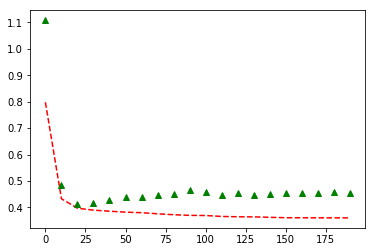

In [53]:
import matplotlib.pyplot as plt
# 損失関数推移
plt.plot(x_collect, train_loss_collect, "r--")
plt.plot(x_collect, valid_loss_collect, "g^")
plt.show()

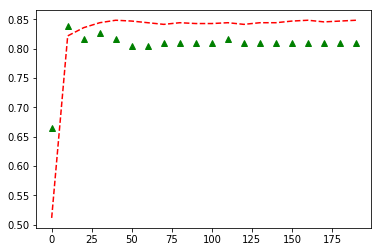

In [54]:
# 正答率
plt.plot(x_collect, train_acc_collect, "r--")
plt.plot(x_collect, valid_acc_collect, "g^")
plt.show()

In [55]:
model=build_neural_network()
restorer=tf.train.Saver()
with tf.Session() as sess:
    restorer.restore(sess,"./titanic.ckpt")
    feed={
        model.inputs:test_df6,
        model.is_training:False
    }
    test_predict=sess.run(model.predicted,feed_dict=feed)
    
test_predict[:10]

INFO:tensorflow:Restoring parameters from ./titanic.ckpt


array([[0.07333683],
       [0.60241616],
       [0.06179546],
       [0.12859084],
       [0.36317527],
       [0.14862578],
       [0.87085587],
       [0.11782184],
       [0.74993783],
       [0.14130594]], dtype=float32)

In [57]:
# 0 or 1に変換
from sklearn.preprocessing import Binarizer
import numpy as np
binarizer=Binarizer(0.5)#閾値0.5
test_predict_result=binarizer.fit_transform(test_predict)
test_predict_result=test_predict_result.astype(np.int32)
test_predict_result[:10]

array([[0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0]], dtype=int32)

In [67]:
# 保存
test =test_passenger_id.to_frame()
test["Survived"]=test_predict_result
test.to_csv("submission.csv",index=False)
test.tail()

,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,0
